<a href="https://colab.research.google.com/github/Park-da-in/ComputerVision_Seminar/blob/main/CV_seminar_week7_epochs100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [3]:
%pwd

'/content/drive/MyDrive/CV_seminar_project'

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

# 1. 데이터 셋 준비하기기

In [5]:
import torch.nn as nn

# 하이퍼 파라미터
batch_size = 8
lr = 0.0001
epochs = 50
optimizer_name = 'adam'
model_name = 'resnet50'
criterion = nn.CrossEntropyLoss().to(device) # cost function

In [6]:
from dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os 
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

root_path = '/content/drive/MyDrive/CV_seminar_project'

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# 2. 모델 불러오기기

In [7]:
from torchvision import models # 모델 라이브러리 함수

resnet_50 = models.resnet50(pretrained=True).to(device) # 선행학습 여부

# finetuning
import torch.nn as nn # 파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
from torchsummary import summary # 모델 아키텍쳐 확인하는 함수

summary(resnet_50, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8)

# 3. 모델 학습시키키
모델 저장하기 : 딕셔너리 형식의 pth확장자로 저장이 된다. validation set의 성능이 여태까지 epoch의 성능에서 best일 때의 모델의 가중치를 저장한다.

In [10]:
resnet_50.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                          4.4022

In [11]:
import numpy as np

train_acc_lst = []
train_loss_lst = []

test_acc_lst = []
test_loss_lst = []
epochs = 100

save_dir = '/content/drive/MyDrive/CV_seminar_project'
model_name = 'resnet50'

for epoch in range(1, epochs):
  running_loss = 0.0
  test_running_loss = 0.0

  total = 0
  correct = 0
  
  train_acc = 0
  test_acc = 0

  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)
    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화

    output = resnet_50(train_img) # 모델에 입력
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    running_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1 )
    
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct/total)

  running_loss = round(running_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  
  print(f'Trainset{epoch}/{epochs} Loss : {running_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(running_loss)


  total = 0
  correct = 0
  resnet_50.eval()
  with torch.no_grad():
    for ii, (valid_img, valid_label) in enumerate(valid_loader):
          # gpu에 할당
      valid_img = valid_img.to(device)
      valid_label = valid_label.to(device)

      output = resnet_50(valid_img) # 모델에 입력
      loss = criterion(output, valid_label)

      # loss & acc
      test_running_loss += loss.item()
      _, predictions = torch.max(output.data ,dim = 1 )
      
      total += valid_label.size(0)
      correct += (predictions == valid_label).sum().item()
      test_acc += 100 * (correct/total)

  test_running_loss = round(test_running_loss/(ii+1), 3) # 소수점 반올림
  test_acc = round(test_acc/(ii+1), 3)
  print(f'Validset{epoch}/{epochs} Loss : {test_running_loss}, Accuracy : {test_acc}% \n')
  test_acc_lst.append(test_acc)
  test_loss_lst.append(test_running_loss)

  if np.max(test_acc_lst) <= test_acc: # 현재 에포크의 test_acc가 가장 좋은 성능이라면
    weight = resnet_50.state_dict() # 지금 모델의 가중치를 
    check_point = {
        'net' : weight,

        'test_loss' : test_running_loss,
        'train_loss' : running_loss,

        'train_acc' : train_acc,
        'test_acc' : test_acc,
    }
    
    torch.save(check_point, save_dir + f'/{model_name}.pth')
  

Trainset1/100 Loss : 0.851, Accuracy : 53.089%
Validset1/100 Loss : 0.656, Accuracy : 69.454% 

Trainset2/100 Loss : 0.676, Accuracy : 70.935%
Validset2/100 Loss : 0.402, Accuracy : 84.006% 

Trainset3/100 Loss : 0.61, Accuracy : 75.927%
Validset3/100 Loss : 0.507, Accuracy : 77.564% 

Trainset4/100 Loss : 0.572, Accuracy : 75.875%
Validset4/100 Loss : 0.562, Accuracy : 76.253% 

Trainset5/100 Loss : 0.506, Accuracy : 79.651%
Validset5/100 Loss : 0.311, Accuracy : 85.73% 

Trainset6/100 Loss : 0.457, Accuracy : 81.889%
Validset6/100 Loss : 0.428, Accuracy : 85.208% 

Trainset7/100 Loss : 0.457, Accuracy : 83.079%
Validset7/100 Loss : 0.363, Accuracy : 84.358% 

Trainset8/100 Loss : 0.463, Accuracy : 86.212%
Validset8/100 Loss : 0.408, Accuracy : 85.853% 

Trainset9/100 Loss : 0.375, Accuracy : 84.201%
Validset9/100 Loss : 0.258, Accuracy : 92.862% 

Trainset10/100 Loss : 0.4, Accuracy : 82.682%
Validset10/100 Loss : 0.379, Accuracy : 87.843% 

Trainset11/100 Loss : 0.343, Accuracy : 87

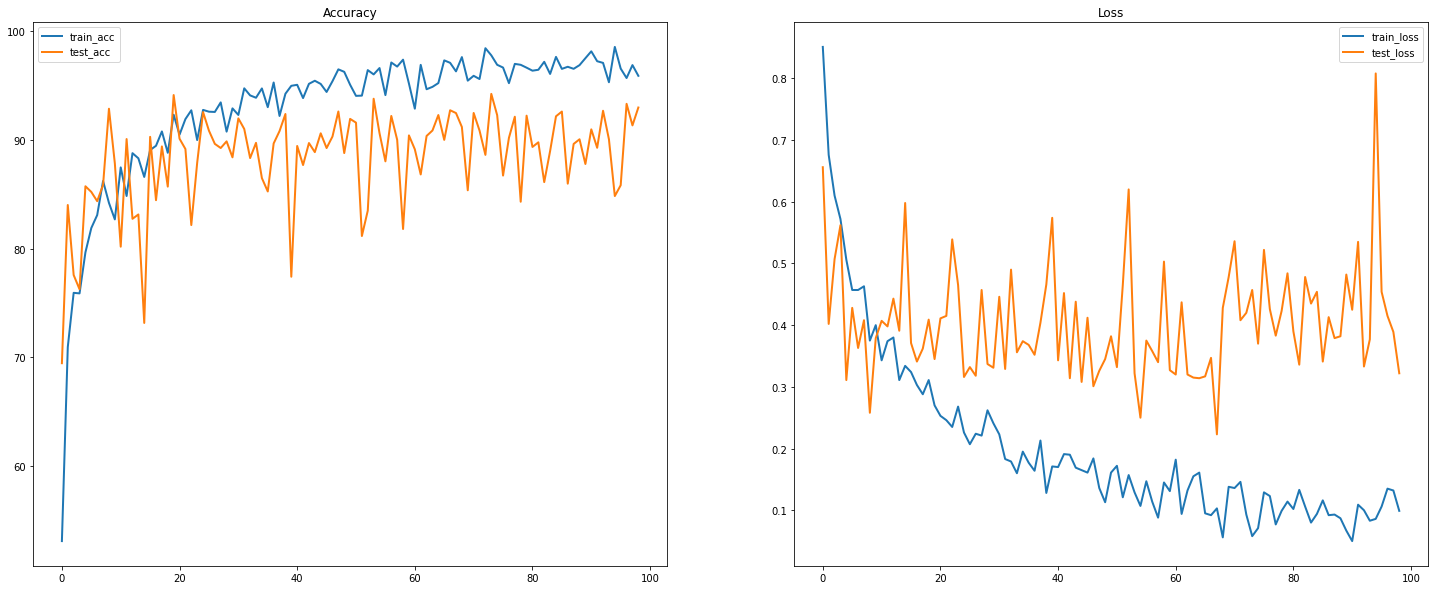

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (25, 10))

axes[0].plot(np.arange(len(train_acc_lst)), train_acc_lst, label = 'train_acc', linewidth=2)
axes[0].plot(np.arange(len(test_acc_lst)), test_acc_lst, label = 'test_acc', linewidth=2)
axes[0].set_title('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(np.arange(len(train_loss_lst)), train_loss_lst, label = 'train_loss', linewidth=2)
axes[1].plot(np.arange(len(test_loss_lst)), test_loss_lst, label = 'test_loss', linewidth=2)
axes[1].set_title('Loss')
axes[1].legend(loc='best')